# Image Inpainting Using GLIDE
A more user friendly notebook derived from the original in the **glide-text2im** GitHub repo, that shows how to use filtered GLIDE to fill in a masked region of an image, conditioned on a text prompt.  
Here's the [link](https://arxiv.org/abs/2112.10741) to the paper.  
The code in this notebook supports execution on CPU or GPU. Anyway, A GPU runtime is suggested to keep the sampling execution within a minute.

Clone the official GitHub repository.

In [1]:
!git clone https://github.com/openai/glide-text2im.git
%cd glide-text2im

Cloning into 'glide-text2im'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 42 (delta 8), reused 16 (delta 4), pack-reused 10
Unpacking objects: 100% (42/42), done.
/content/glide-text2im


## Settings

Add the *glide_text2im* package to the Python *sys.path*.

In [2]:
%set_env PYTHONPATH=/content/packnet-sfm/packnet_sfm:/env/python

env: PYTHONPATH=/content/packnet-sfm/packnet_sfm:/env/python


Import the necessary packages.

In [3]:
from typing import Tuple

from IPython.display import display
from PIL import Image
import numpy as np
import torch as th
import torch.nn.functional as F

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

Check if a GPU is available. If not, switch execution to CPU.

In [4]:
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

Create the base model.

In [5]:
options = model_and_diffusion_defaults()
options['inpaint'] = True
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base-inpaint', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385037638


Create the upsampler model.

In [6]:
options_up = model_and_diffusion_defaults_upsampler()
options_up['inpaint'] = True
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample-inpaint', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398368198


Define a function to display a batch of images inline.

In [7]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

Define a function to convert an image into a multi-dimentional array.

In [8]:
def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

Upload the source image to impaint.

In [9]:
from google.colab import files

uploaded = files.upload()

Saving pexels-francesco-ungaro-1671325.jpg to pexels-francesco-ungaro-1671325.jpg


Implement a form to set the values for the sampling parameters.

In [49]:
#@title Sampling Parameters

prompt = 'An oil painting of a lion' #@param {type:"string"}
batch_size = 1 #@param {type:"slider", min:1, max:8, step:1}
guidance_scale = 5.0 #@param {type:"slider", min:1.0, max:10.0, step:0.1}
upsample_temp = 0.997 #@param {type:"slider", min:0, max:1, step:0.1}

Create the mask and display the source image with the mask on top of it.

In [23]:
for key in uploaded.keys():
  uploaded_image = key

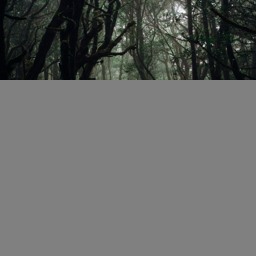

In [50]:
# Source image we are inpainting
source_image_256 = read_image(uploaded_image, size=256)
source_image_64 = read_image(uploaded_image, size=64)

# The mask should always be a boolean 64x64 mask, and then we
# can upsample it for the second stage.
source_mask_64 = th.ones_like(source_image_64)[:, :1]
source_mask_64[:, :, 20:] = 0
source_mask_256 = F.interpolate(source_mask_64, (256, 256), mode='nearest')

# Visualize the image we are inpainting
show_images(source_image_256 * source_mask_256)

## Sampling from Base Model

Create the text tokens to feed to the model.

In [51]:
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

Create the empty classifier-free guidance tokens.

In [52]:
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

Pack the tokens together into model *kwargs*.

In [53]:
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image
    inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),
)

Implement a classifier-free guidance sampling function.

In [41]:
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

Sample from the base model.

In [54]:
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model.del_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

Display the result.

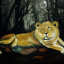

In [55]:
show_images(samples)

## Upsampling the 64x64 Samples

Create the text tokens to feed to the model.

In [56]:
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

Create the model conditioning dict.

In [57]:
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image.
    inpaint_image=(source_image_256 * source_mask_256).repeat(batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_256.repeat(batch_size, 1, 1, 1).to(device),
)

Define a function to force the model to have the exact right *x_start* predictions for the part of the image which is known.

In [58]:
def denoised_fn(x_start):
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

Sampling.

In [59]:
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.p_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model_up.del_cache()

  0%|          | 0/27 [00:00<?, ?it/s]

Display the result.

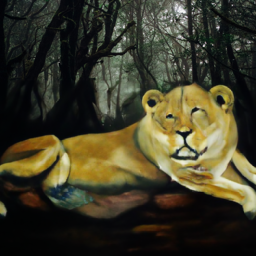

In [60]:
show_images(up_samples)